## Import Data and Set the Right DataTypes

In [1]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta

# from dateutil.relativedelta import relativedelta

%matplotlib inline

# import sklearn

C:\Users\Nachiket\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Import Data

uedf = pd.read_csv("takehome_user_engagement.csv")
udf = pd.read_csv("takehome_users.csv",encoding = "ISO-8859-1")

In [3]:
# Convert UNIX datetime to pandas datetime
# print(udf['last_session_creation_time'].describe())
udf['last_session_creation_time'] = pd.to_datetime(udf['last_session_creation_time'], unit='ms')
print (udf.last_session_creation_time.dtypes)

datetime64[ns]


In [4]:
# Creation Time
udf['creation_time'] = pd.to_datetime(udf['creation_time'])
udf.creation_time.dtypes

dtype('<M8[ns]')

In [5]:
uedf['time_stamp'] = pd.to_datetime(uedf['time_stamp'])
uedf.time_stamp.dtypes

dtype('<M8[ns]')

In [6]:
udf.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-17 04:22:18.810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-17 03:50:37.504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-16 18:48:54.892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-16 20:20:10.168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-16 17:27:29.660,0,0,193,5240.0


## Adopted User

** A user who has logged into the product on three separate days in at least one seven day period **

We can define adpoted user using the following definition and create a corresponding binary class column representing whether a user is 'adopted' or not (1 or 0)

In [7]:
# Group the uedf by user
userlogins = uedf.pivot_table("visited",["user_id","time_stamp"])
userlogins.loc[[1,2]]

visited
user_id time_stamp                  
1       2014-04-22 03:53:30        1
2       2013-11-15 03:45:04        1
        2013-11-29 03:45:04        1
        2013-12-09 03:45:04        1
        2013-12-25 03:45:04        1
        2013-12-31 03:45:04        1
        2014-01-08 03:45:04        1
        2014-02-03 03:45:04        1
        2014-02-08 03:45:04        1
        2014-02-09 03:45:04        1
        2014-02-13 03:45:04        1
        2014-02-16 03:45:04        1
        2014-03-09 03:45:04        1
        2014-03-13 03:45:04        1
        2014-03-31 03:45:04        1

In [8]:
# Let's take user_ids from udf
userids = list(udf.object_id)
userids[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [9]:
adopted = dict.fromkeys(userids) #initialize dictionary with user_id keys

# Now let's go through every user in pivoted df to check if he's 'adopoted or not'

for userid in userids:
    
    adopted[userid] = 0 #User is not 'adopted' is the default
    
    try: # userlogins.loc[userid] raises exception if there are no logins associated in uedf / userlogins. This is to handle users with no logins.
    
        logins = userlogins.loc[userid]


            # Check total logins
    #         print (len(logins))
        if len(logins) >= 3:
#             print ("pass")

            # Check if there are at least 3 logins within the span of 7 days or less        
            for i in range(2, len(logins)):
                td = logins.index[i] - logins.index[i-2] # Timedelta between 3 consecutive logins
                if td <= pd.Timedelta('7 days'): # User is 'adopted' if td is less than or equal to 7 days.
                    adopted[userid] = 1
    except:
        pass

In [10]:
# Add the adoped column to udf

udf['Adopted'] = udf['object_id'].map(adopted)
udf['Adopted'].value_counts()
# udf.head()

0    10344
1     1656
Name: Adopted, dtype: int64

# Supervised Leaning - Classification

Now that we have defined a 'y' column for adoption, we can run a supervised learning algorithm prediction.

**Features available are as follows -**

name, email, creation_source, creation_time, last_session_creation_time, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id, invited_by_user_id

### Null Values
Let's skip imputation and delete the rows with missing values for convinience

In [11]:
cols = list(udf.columns)
for column in cols:
    missing_count = udf[column].isnull().values.sum()
    print (column, " - ", missing_count)

    if missing_count > 0:
#         null_cols.append(column)
#         udf = udf.loc[udf[column].notnull()]
        pass
    
    missing_count = udf[column].isnull().values.sum()
    print (column, " - ", missing_count,'\n')

object_id  -  0
object_id  -  0 

creation_time  -  0
creation_time  -  0 

name  -  0
name  -  0 

email  -  0
email  -  0 

creation_source  -  0
creation_source  -  0 

last_session_creation_time  -  3177
last_session_creation_time  -  3177 

opted_in_to_mailing_list  -  0
opted_in_to_mailing_list  -  0 

enabled_for_marketing_drip  -  0
enabled_for_marketing_drip  -  0 

org_id  -  0
org_id  -  0 

invited_by_user_id  -  5583
invited_by_user_id  -  5583 

Adopted  -  0
Adopted  -  0 



In [12]:
# Change NaNs for invited by user id to 0
udf.invited_by_user_id.loc[udf.invited_by_user_id.isnull()] = 0

C:\Users\Nachiket\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
#Last Session Creation Time
print ( " How many of those who do not have the last session information are adopted? -",len(udf[['last_session_creation_time','Adopted']].loc[(udf.last_session_creation_time.isnull()) & (udf.Adopted == 1)]))

 How many of those who do not have the last session information are adopted? - 0


This makes sense as these users might have never logged in, and hence, they aren't adopted.

## Let's design some new variables

### A binary classed based on last_session_creation_time NaNs

In [14]:
udf['last_session_binary'] = 1
udf['last_session_binary'].loc[udf.last_session_creation_time.isnull()] = 0

C:\Users\Nachiket\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Account Age based on creation time and last session creation time

In [15]:
udf['account_age'] = udf['creation_time'] - udf['last_session_creation_time']
udf['account_age'].loc[udf.account_age.isnull()] = 0
udf['account_age'] = udf['account_age'].dt.total_seconds()

C:\Users\Nachiket\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Binary Class Based on invited by user id

In [16]:
udf['invitation'] = 1
udf['invitation'].loc[udf.invited_by_user_id == 0] = 0

C:\Users\Nachiket\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Name and Email into their length

In [17]:
udf['namelen'] = udf['name'].apply(lambda x: len(x))
udf['emaillen'] = udf['email'].apply(lambda x: len(x))

### Encode creation_source

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
udf['creation_source'] = le.fit_transform(udf['creation_source'])

In [19]:
# Removing timestamps, strings
udf = udf.drop(['creation_time','last_session_creation_time','name','email','object_id'],axis=1)
udf['account_age'] = round(udf['account_age']/1000000000, 3)
udf.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Adopted,last_session_binary,account_age,invitation,namelen,emaillen
0,0,1,0,11,10803.0,0,1,1.397,1,14,24
1,1,0,0,1,316.0,1,1,1.383,1,13,22
2,1,0,0,94,1525.0,0,1,1.362,1,17,26
3,0,0,0,1,5151.0,0,1,1.368,1,15,25
4,0,0,0,193,5240.0,0,1,1.357,1,9,18


In [20]:
len(udf['Adopted'].loc[udf['Adopted'].notnull()])

12000

## Random Forest

In [21]:
# Train Test Split
from sklearn.model_selection import train_test_split

# udf = udf.loc[np.isinf(udf)]

features = udf.drop('Adopted',axis=1)
# print("Contains Null Values -\n\n",np.isnan(features.all())) #and gets True
# print("Contains Infinite Values -\n\n",np.isinf(features).all()) #and gets True

X, Xtest, y, ytest = train_test_split(features, udf['Adopted'],random_state=1,test_size=0.7)

In [22]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, recall_score
import matplotlib.pyplot as plt

def roccurve(trainedevaluator,plotting=False,X=X,y=y,Xtest=Xtest,ytest=ytest):
        """ Plots ROC Curve and return area under the curve """
    
        #fit
#         trainedevaluator.fit(X,y)
        
        #Find probabilities
        preds = trainedevaluator.predict_proba(Xtest)[:,1]
        
        #ROC
        fpr, tpr, _ = roc_curve(ytest, preds)
        
        #Area Under the curve
        area = auc(fpr,tpr)
        
        #Plot
        if plotting == True:
            plt.figure(figsize=(6,6))
#            plt.xlim([0,1])
#            plt.ylim([0,1])
            plt.title("ROC",fontsize=12)
            plt.xlabel("False Positive Rate")
            plt.ylabel("Ttrue Positive Rate")
            plt.plot(fpr,tpr)
            plt.plot([0,1],[0,1],'--',alpha=0.5)
        
        return area
    
    
    
def prediction(clf,X=X,y=y,Xtest=Xtest,ytest=ytest):

    preds = clf.predict(Xtest)
    cm = confusion_matrix(ytest, preds)

    print ("\nClassification Report on the Training data -\n", classification_report(y, clf.predict(X)))

    print("Accuracy Score =", accuracy_score(ytest, preds))
    print("Recall Score = ", recall_score(ytest,preds))

    print("\nConfusion Matrix -\n",cm)
    print("\nClassification Report -\n",classification_report(ytest, preds))
    try:
        print("Area under the ROC curve = {}".format(roccurve(clf)))
    except AttributeError:
        print ("Cannot draw ROC - predict_proba is not an attribute")

### Prediction

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
# Initial Run
rf = RandomForestClassifier(n_estimators=100, min_samples_split=10)
rf.fit(X,y)

prediction(rf)


Classification Report on the Training data -
              precision    recall  f1-score   support

          0       0.90      1.00      0.95      3150
          1       1.00      0.22      0.35       450

avg / total       0.91      0.90      0.87      3600

Accuracy Score = 0.855357142857
Recall Score =  0.0

Confusion Matrix -
 [[7185    9]
 [1206    0]]

Classification Report -
              precision    recall  f1-score   support

          0       0.86      1.00      0.92      7194
          1       0.00      0.00      0.00      1206

avg / total       0.73      0.86      0.79      8400

Area under the ROC curve = 0.7174144567681471


### The Data is imbalanced. Let's try to improve our data for better predictions

Let's start by modifying RandomForestClassifier with an extra parameter class_weight='balanced' or 'balanced_subsample'

In [32]:
# Initial Run
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=50,class_weight='balanced' )
rf.fit(X,y)

prediction(rf)


Classification Report on the Training data -
              precision    recall  f1-score   support

          0       0.98      0.53      0.69      3150
          1       0.22      0.93      0.36       450

avg / total       0.89      0.58      0.65      3600

Accuracy Score = 0.56
Recall Score =  0.870646766169

Confusion Matrix -
 [[3654 3540]
 [ 156 1050]]

Classification Report -
              precision    recall  f1-score   support

          0       0.96      0.51      0.66      7194
          1       0.23      0.87      0.36      1206

avg / total       0.85      0.56      0.62      8400

Area under the ROC curve = 0.739116540824743


## Using another package - Imbalanced Learn

In [26]:
from imblearn import over_sampling as os
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced
# from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

In [39]:
# Create Pipeline
pipeline = pl.make_pipeline(os.SMOTE(), RandomForestClassifier(n_estimators=500, min_samples_leaf=200))

pipeline.fit(X,y)

prediction(pipeline)


Classification Report on the Training data -
              precision    recall  f1-score   support

          0       0.92      0.74      0.82      3150
          1       0.22      0.52      0.31       450

avg / total       0.83      0.71      0.76      3600

Accuracy Score = 0.690595238095
Recall Score =  0.495854063018

Confusion Matrix -
 [[5203 1991]
 [ 608  598]]

Classification Report -
              precision    recall  f1-score   support

          0       0.90      0.72      0.80      7194
          1       0.23      0.50      0.32      1206

avg / total       0.80      0.69      0.73      8400

Area under the ROC curve = 0.7101622943571457


(-1, 10)

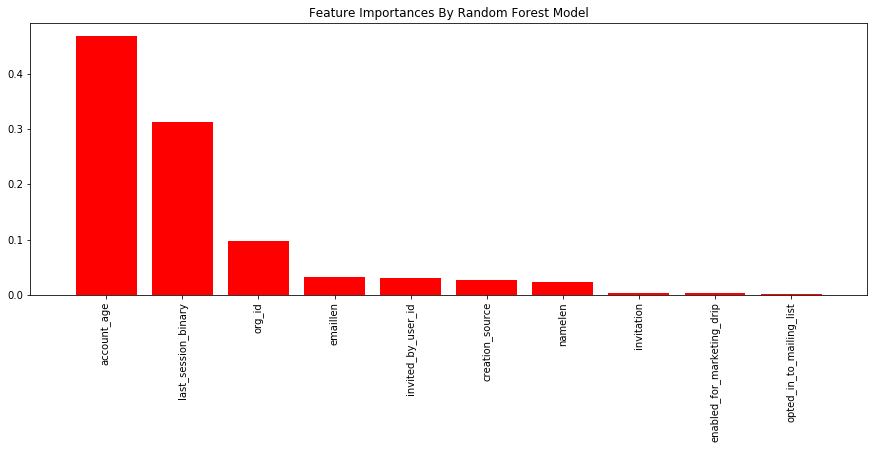

In [40]:
predictors = list(features.columns)

importances=rf.feature_importances_

indices = np.argsort(importances)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
    
plt.figure(figsize=(15,5))
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), importances[indices],
       color="r")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)])